In [25]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
import config


In [26]:
df = pd.read_csv('../../data/data_daily_with_aqi.csv')
target = 'AQI'
city ='北京'
df_tgt = df[df.type==target].drop('type',axis=1)
df_tgt_ct = df_tgt[['date',city]].rename(columns={'date':'ds',city:'y'})
df_tgt_ct = df_tgt_ct.dropna()

In [27]:
df_tgt_ct.set_index(pd.DatetimeIndex(df_tgt_ct['ds']),inplace=True)

In [28]:
df_tgt_ct = df_tgt_ct.drop('ds',axis=1).resample('M').mean()

In [30]:

model = pm.auto_arima(df_tgt_ct.y, start_p=1, start_q=1,
                      information_criterion='aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=826.030, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=879.225, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=824.796, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=839.682, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1050.701, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=826.011, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=828.024, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=836.019, Time=0.00 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.165 seconds


In [31]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   88
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -409.398
Date:                Mon, 16 May 2022   AIC                            824.796
Time:                        22:45:10   BIC                            832.228
Sample:                             0   HQIC                           827.791
                                 - 88                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     25.6122      7.706      3.324      0.001      10.508      40.716
ar.L1          0.7086      0.064     11.146      0.000       0.584       0.833
sigma2       638.2624     88.674      7.198      0.0

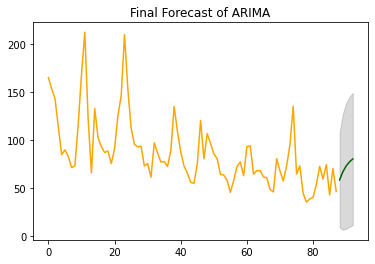

In [36]:
y = df_tgt_ct.y.reset_index(drop=True)
# Forecast
n_periods = 5
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df_tgt_ct.y), len(df_tgt_ct.y)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(y[:],color = 'orange')
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of ARIMA")
plt.show()